### loading packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from helpers import *

### loading data

In [2]:
df = read_data()

读好数据啦！


In [3]:
df_encode = encode(df)

使用了OneHotEncoding，得到：
(745515, 65)


In [4]:
X_train, X_test, y_train, y_test = over_split(df_encode)

在Over Sampling之后有
没问题的 517084 个
有问题的 517084 个


### Model

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

#### KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 31), 'weights': ['uniform', 'distance']}

# grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train[:3000], y_train[:3000])

best_knn_params = grid_search.best_params_
best_knn_estimator = grid_search.best_estimator_

print("Best Hyperparameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Hyperparameters:
{'n_neighbors': 1, 'weights': 'uniform'}


In [20]:
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_knn_model.fit(X_train,y_train)
y_knn_pred = best_knn_model.predict(X_test)
y_knn_pred_proba = best_knn_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[211607   9941]
 [  1946    161]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    221548
           1       0.02      0.08      0.03      2107

    accuracy                           0.95    223655
   macro avg       0.50      0.52      0.50    223655
weighted avg       0.98      0.95      0.96    223655


Accuracy Score:
0.94685117703606


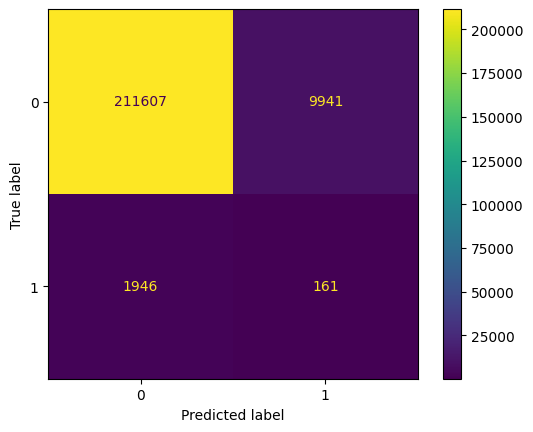

In [64]:
cm = confusion_matrix(y_test, y_knn_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_knn_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_knn_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_knn_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_knn_pred))

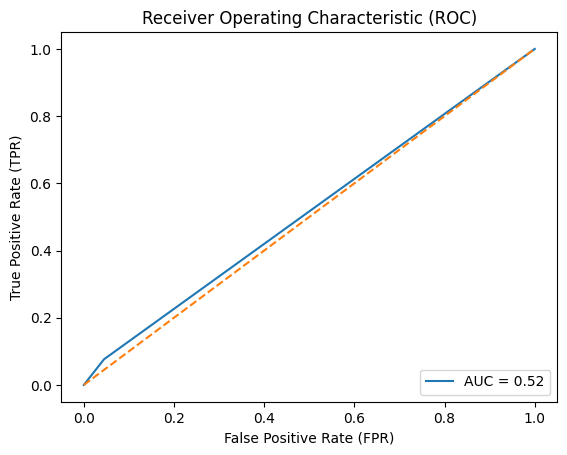

0.515770661309336

In [82]:
auc_related(y_test,y_knn_pred_proba)

#### GBDT

In [83]:
from sklearn.ensemble import GradientBoostingClassifier

In [85]:
gbdt = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(gbdt, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train[:3000], y_train[:3000])

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='roc_auc')

In [86]:
best_gbdt_params = grid_search.best_params_
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 1.0}


In [87]:
best_gbdt_model = GradientBoostingClassifier(**best_gbdt_params)
best_gbdt_model.fit(X_train,y_train)
y_gbdt_pred = best_gbdt_model.predict(X_test)
y_gbdt_pred_proba = best_gbdt_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[219916   1632]
 [  1794    313]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    221548
           1       0.16      0.15      0.15      2107

    accuracy                           0.98    223655
   macro avg       0.58      0.57      0.57    223655
weighted avg       0.98      0.98      0.98    223655


Accuracy Score:
0.9846817643245177


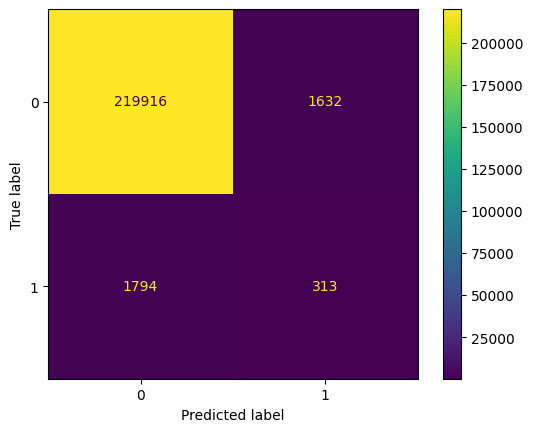

In [88]:
cm = confusion_matrix(y_test, y_gbdt_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_gbdt_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_gbdt_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_gbdt_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_gbdt_pred))

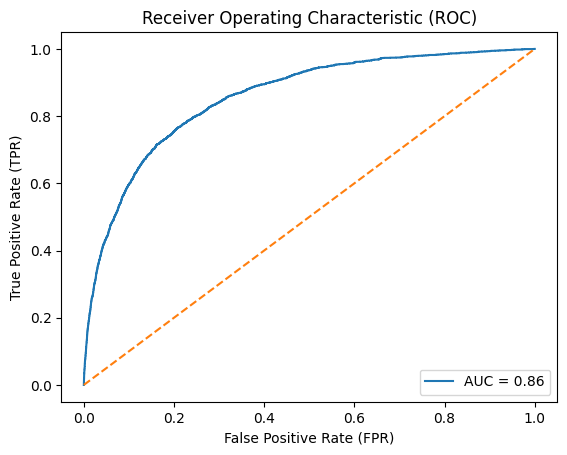

0.8565526149955481

In [89]:
auc_related(y_test,y_gbdt_pred_proba)

#### XGBoost

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train[:3000], y_train[:3000])

In [11]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
param_dist = {
    'n_estimators': range(100, 1000, 50),
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': range(3, 10),
    'min_child_weight': range(1, 6),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'gamma': np.linspace(0, 0.5, 6),
    'reg_alpha': [0, 1e-1, 1, 10, 100],
    'reg_lambda': [0, 1e-1, 1, 10, 100],
    'scale_pos_weight': [1, 2, 3, 4]
}

# n_iter determines the number of random parameter combinations to try
n_iter = 20

random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=n_iter, cv=5,
    scoring='roc_auc', verbose=1, random_state=42
)

random_search.fit(X_train.iloc[:3000], y_train.iloc[:3000])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'max_depth': range(3, 10),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': range(100, 1000, 50),
                                        'reg_alpha': [0, 0.1, 1, 10, 100],
                                        'reg_lambda': [0, 0.1, 1, 10, 100],
                                        'scale_pos_weight': [1, 2, 3, 4],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='roc_auc', verbose=1)

In [13]:
best_xgb_params = random_search.best_params_
print("Best Hyperparameters:")
print(best_xgb_params)

Best Hyperparameters:
{'subsample': 0.6, 'scale_pos_weight': 1, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 800, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.021544346900318832, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.6}


In [14]:
best_xgb_model = XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train,y_train)
y_xgb_pred = best_xgb_model.predict(X_test)
y_xgb_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[221431    117]
 [  2010     97]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    221548
           1       0.45      0.05      0.08      2107

    accuracy                           0.99    223655
   macro avg       0.72      0.52      0.54    223655
weighted avg       0.99      0.99      0.99    223655


Accuracy Score:
0.9904898169055018


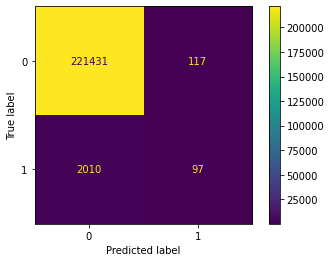

In [15]:
cm = confusion_matrix(y_test, y_xgb_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_xgb_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_xgb_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_xgb_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_xgb_pred))

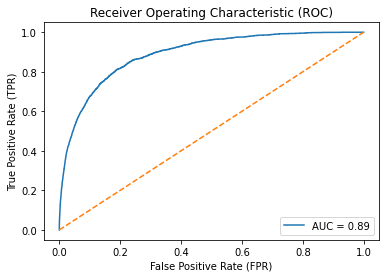

0.8897568173904172

In [16]:
auc_related(y_test,y_xgb_pred_proba)

#### MLP

In [98]:
from sklearn.neural_network import MLPClassifier

In [99]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'batch_size': [32, 64, 128],
    'max_iter': [100, 200, 300],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.01],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.1]
}

mlp_model = MLPClassifier(random_state=42)
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=5, 
                           scoring='roc_auc', n_jobs=64)
grid_search.fit(X_train[:3000], y_train[:3000])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=64,
             param_grid={'activation': ['relu', 'tanh'], 'alpha': [0.01],
                         'batch_size': [32, 64, 128],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)],
                         'learning_rate': ['adaptive'],
                         'learning_rate_init': [0.1],
                         'max_iter': [100, 200, 300], 'solver': ['adam']},
             scoring='roc_auc')

In [100]:
best_mlp_params = grid_search.best_params_
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'activation': 'tanh', 'alpha': 0.01, 'batch_size': 64, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'max_iter': 100, 'solver': 'adam'}


In [101]:
best_mlp_model = MLPClassifier(**best_mlp_params)
best_mlp_model.fit(X_train,y_train)
y_mlp_pred = best_mlp_model.predict(X_test)
y_mlp_pred_proba = best_mlp_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[     0 221548]
 [     0   2107]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    221548
           1       0.01      1.00      0.02      2107

    accuracy                           0.01    223655
   macro avg       0.00      0.50      0.01    223655
weighted avg       0.00      0.01      0.00    223655


Accuracy Score:
0.00942075965214281


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

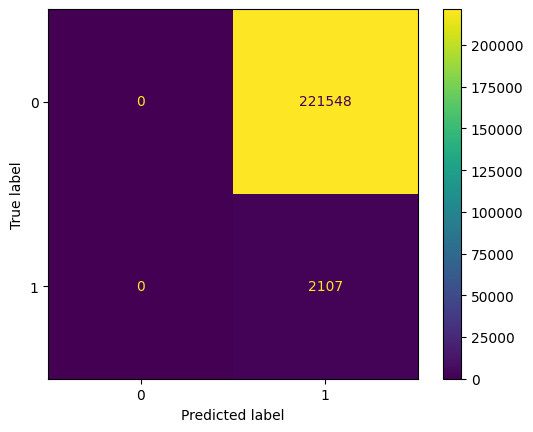

In [102]:
cm = confusion_matrix(y_test, y_mlp_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_mlp_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_mlp_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_mlp_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_mlp_pred))

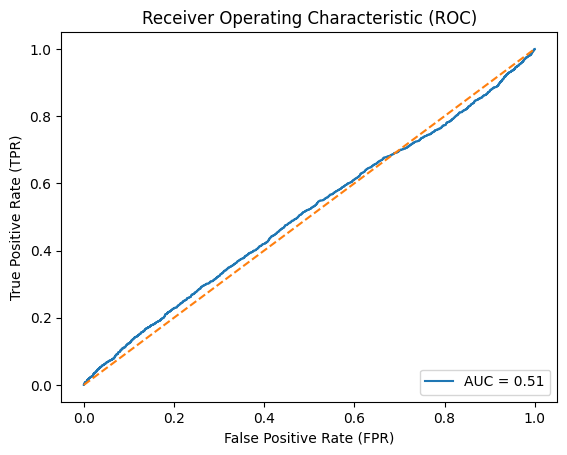

0.5087283188099195

In [103]:
auc_related(y_test,y_mlp_pred_proba)